In [148]:
import json
import time
import warnings
import math

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42

# 5 pieces of data -> 3 pieces of data
#Source: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/12_quantum_autoencoder.html

In [149]:
#Import S&P500 Data
import yfinance as yf
import numpy as np
import pandas as pd
from pandas import DataFrame
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
del sp500["Dividends"]
del sp500["Stock Splits"]

In [150]:
#Clean data and create intended features
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Label"] = 2 * (sp500["Tomorrow"] > sp500["Close"]).astype(int) - 1

#Only uses more recent data
sp500 = sp500.loc["2020-01-01":].copy()

#Includes rolling averages for additional features
horizons = [3,10,25]
new_predictors = []
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    #Ratio of closing date from yesterday over rolling average of the closing dates
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    #Sum of labels divided by number of days in rolling average
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = (sp500.shift(1).rolling(horizon).sum()["Label"])/horizon
    
    new_predictors += [ratio_column, trend_column]
    
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Label,Close_Ratio_3,Trend_3,Close_Ratio_10,Trend_10,Close_Ratio_25,Trend_25
Date,,,,,,,,,,,,,
2020-02-07 00:00:00-05:00,3335.540039,3341.419922,3322.120117,3327.709961,3733920000,3352.090088,1,0.997497,0.333333,1.012781,0.2,1.012828,0.20
2020-02-10 00:00:00-05:00,3318.280029,3352.260010,3317.770020,3352.090088,3462730000,3357.750000,1,1.003061,0.333333,1.016845,0.4,1.018794,0.28
2020-02-11 00:00:00-05:00,3365.870117,3375.629883,3352.719971,3357.750000,3762940000,3379.449951,1,1.003557,0.333333,1.016050,0.4,1.019133,0.28
2020-02-12 00:00:00-05:00,3370.500000,3381.469971,3369.719971,3379.449951,3930910000,3373.939941,-1,1.004863,1.000000,1.019345,0.6,1.023951,0.36
2020-02-13 00:00:00-05:00,3365.899902,3385.090088,3360.520020,3373.939941,3500890000,3380.159912,1,1.001056,0.333333,1.014919,0.4,1.020786,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-10 00:00:00-04:00,5167.879883,5178.430176,5138.700195,5160.640137,3845930000,5199.060059,1,0.994155,-0.333333,0.990747,0.0,0.995107,-0.04
2024-04-11 00:00:00-04:00,5172.950195,5211.779785,5138.770020,5199.060059,3509380000,5123.410156,-1,1.001771,0.333333,0.999071,0.0,1.001787,-0.04
2024-04-12 00:00:00-04:00,5171.509766,5175.029785,5107.939941,5123.410156,3963220000,5061.819824,-1,0.992709,-0.333333,0.987017,-0.2,0.987469,-0.12


In [151]:
#Makes the data into percentages so it can be encoded into the quantum circuit
sp500["Close"] = (sp500["Close"]-sp500["Open"])/sp500["Open"]
sp500["High"] = (sp500["High"]-sp500["Open"])/sp500["Open"]
sp500["Low"] = (sp500["Low"]-sp500["Open"])/sp500["Open"]
sp500["Volume"] = (sp500["Volume"] - sp500["Volume"].min())/sp500["Volume"].max()

#Drops data that we don't want to use in training
predictors = sp500.drop(["Open", "Tomorrow","Label"], axis=1)
predictors = DataFrame.to_numpy(predictors)
labels = (DataFrame.to_numpy(sp500))[:,6]
num_features = np.size(predictors, axis=1)

In [152]:
def make_amplitude_encoding_circuit(input):

    def amplitude_encoding(circuit, values):
        circuit.initialize(values)
        return circuit
    
    def normalize_vector(values):
        bottom = 0;
        for val in values:
            bottom = bottom + val**2;
        bottom = bottom**0.5;
        for i in range(len(values)):
            values[i] = values[i] / bottom;
        return values;
    
    def pad_vector(values):
        while not math.log(len(values), 2).is_integer():
            values.append(0);
    
    input_data = input
    input_data_norm = normalize_vector(input)
    pad_vector(input)
    amplitude_encoding_circuit = amplitude_encoding(QuantumCircuit(4), input_data_norm)
    tmp_circuit = QuantumCircuit(1)
    final_circuit = QuantumCircuit(5);
    final_circuit.compose(amplitude_encoding_circuit, [0,1,2,3], inplace=True)
    final_circuit.compose(tmp_circuit, [4], inplace=True)
    final_circuit.draw("mpl", style="clifford")
    return final_circuit

In [158]:
amplitude_list = []
for day in predictors:
    tmp = make_amplitude_encoding_circuit(day.tolist())
    amplitude_list.append(tmp)

In [159]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

10


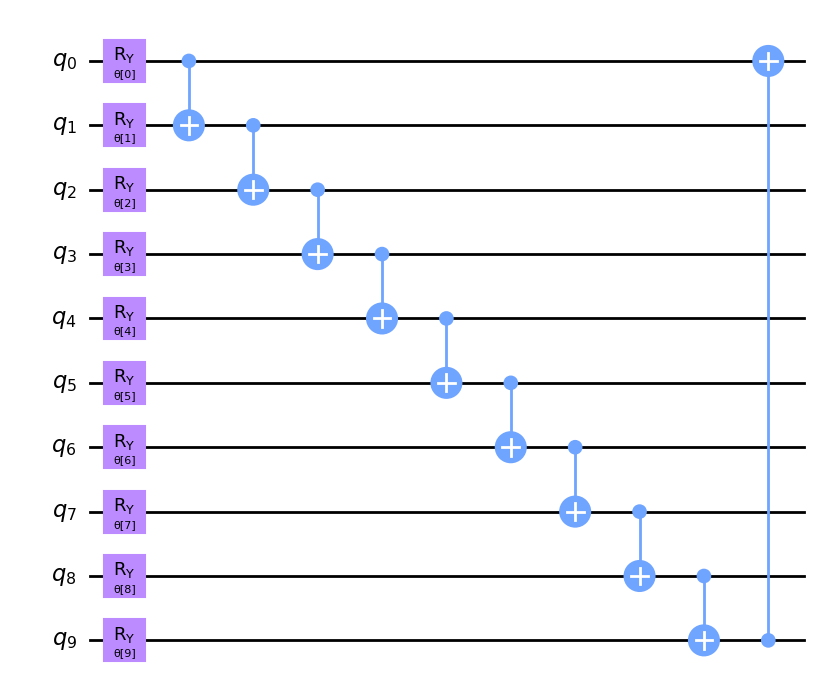

In [160]:
#Function to create the gates with parameters that we will modify through ML techniques
num_params = num_features
print(num_params);
def parametrized_gates(params):
    target = QuantumCircuit(num_features)
        
    for i in range(num_features):
        target.ry(params[i], i)
        
    for i in range(num_features-1):
        target.cx(i, i+1)
        
    target.cx(9,0)
    
    return target

#Draws the ciruit for parametrized gate
params = ParameterVector("θ", length=num_params)
circuit = parametrized_gates(params)
circuit.draw("mpl", style="clifford")

10


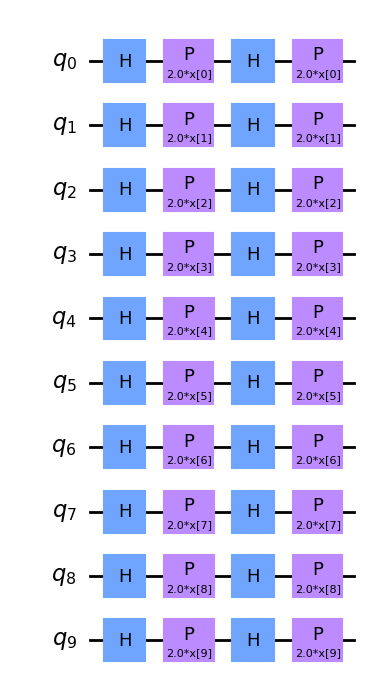

In [161]:
#Qiskits default circuit for encoding data
from qiskit.circuit.library import ZFeatureMap
feature_map = ZFeatureMap(np.size(predictors, axis=1))
print(np.size(predictors, axis=1));
feature_map.decompose().draw("mpl", style="clifford")

_____________________________________________________________
This makes the circuit that reduced dimensionality to 1 qubit

In [162]:
def make_auto_encoder_circuit():
    def ansatz(num_qubits):
        return RealAmplitudes(num_qubits, reps=5)
    def auto_encoder_circuit(num_latent, num_trash):
        qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
        cr = ClassicalRegister(1, "c")
        circuit = QuantumCircuit(qr, cr)
        #circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
        circuit.compose(ansatz(num_latent + num_trash), {0,1,2,3,4}, inplace=True)
        circuit.barrier()
        tmp_circuit = circuit
        auxiliary_qubit = num_latent + 2 * num_trash
        # swap test
        circuit.h(auxiliary_qubit)
        for i in range(num_trash):
            circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)
    
        circuit.h(auxiliary_qubit)
        circuit.measure(auxiliary_qubit, cr[0])
        return circuit
    
    
    num_latent = 2 # 3 qubits with the data at end
    num_trash = 3
    circuit = auto_encoder_circuit(num_latent, num_trash)
    circuit.draw(output="mpl", style="clifford")
    ae = auto_encoder_circuit(num_latent, num_trash)
    qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
    qc = qc.compose(ae)
    qc.draw(output="mpl", style="clifford")

    # Here we define our interpret for our SamplerQNN
    def identity_interpret(x):
        return x
    
    
    qnn = SamplerQNN(
        circuit=qc,
        input_params=[],
        weight_params=ae.parameters,
        interpret=identity_interpret,
        output_shape=2,
    )
    def cost_func_domain(params_values):
        probabilities = qnn.forward([], params_values)
        # we pick a probability of getting 1 as the output of the network
        cost = np.sum(probabilities[:, 1])
    
        # plotting part
        clear_output(wait=True)
        objective_func_vals.append(cost)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(objective_func_vals)), objective_func_vals)
        plt.show()
        return cost
    
    opt = COBYLA(maxiter=10)
    initial_point = algorithm_globals.random.random(ae.num_parameters)
    
    objective_func_vals = []
    # make the plot nicer
    plt.rcParams["figure.figsize"] = (12, 6)
    
    start = time.time()
    opt_result = opt.minimize(cost_func_domain, initial_point)
    elapsed = time.time() - start
    
    print(f"Fit in {elapsed:0.2f} seconds")

    for index, instruction in enumerate(qc.data):
        print(index, instruction.operation.name, [ circuit.find_bit(q).index for q in instruction.qubits]) 

    del qc.data[-1]
    del qc.data[-1]
    del qc.data[-1]
    del qc.data[-1]
    del qc.data[-1]
    del qc.data[-1]
    
    return qc

This marks the end of the encoding and dimensionality reduction algo

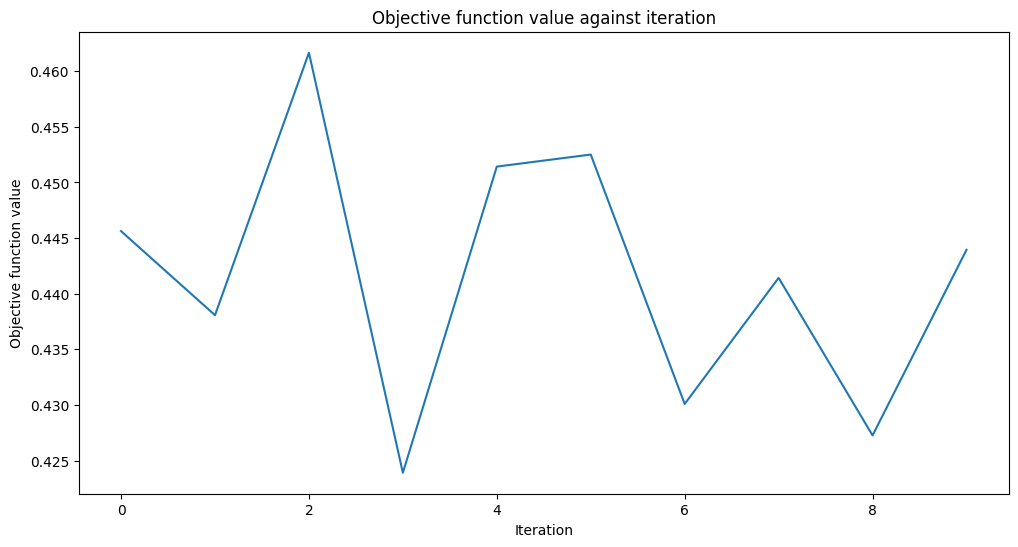

Fit in 1.45 seconds
0 RealAmplitudes [0, 1, 2, 3, 4]
1 barrier [0, 1, 2, 3, 4, 5, 6, 7, 8]
2 h [8]
3 cswap [8, 2, 5]
4 cswap [8, 3, 6]
5 cswap [8, 4, 7]
6 h [8]
7 measure [8]


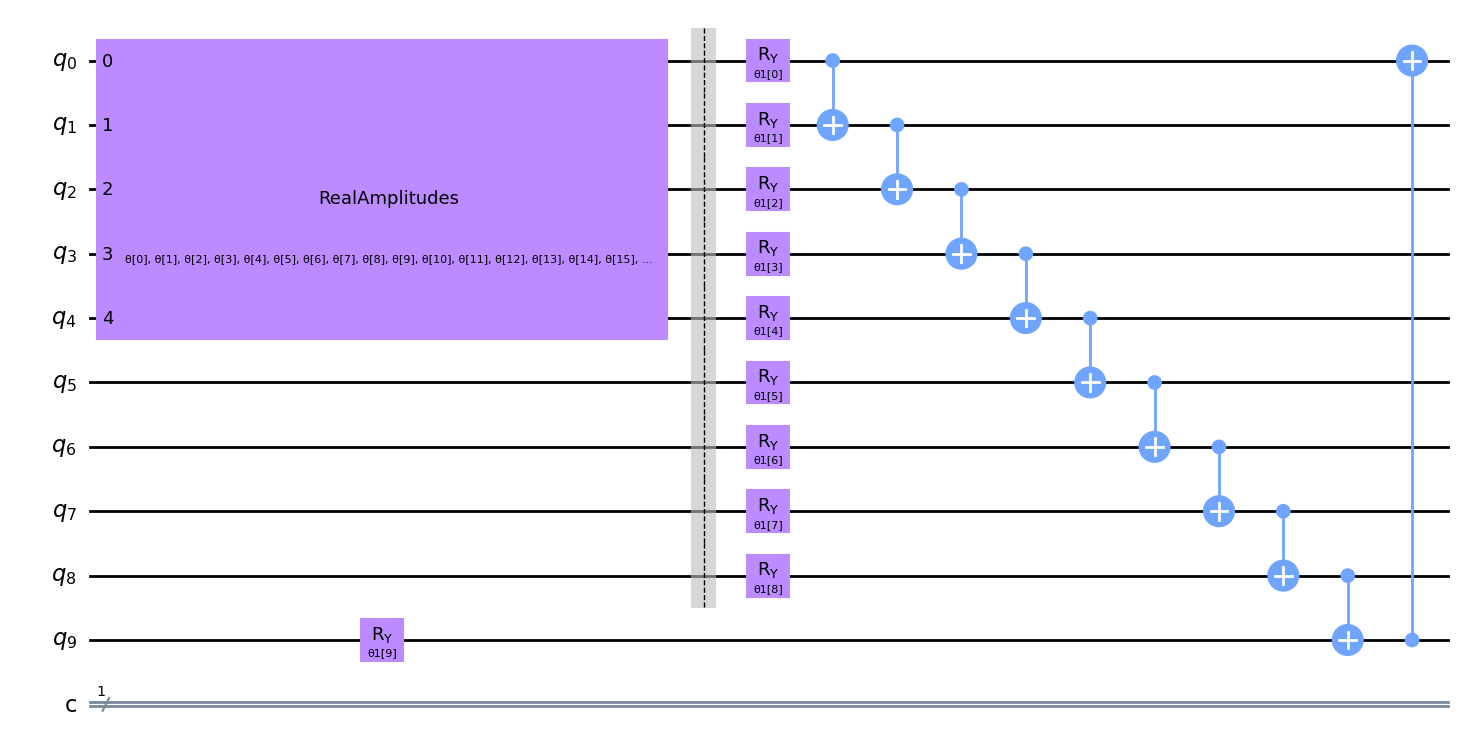

In [163]:
#Sets up full circuit with inputs and network
network = parametrized_gates(ParameterVector("θ1", length=num_params))
#network.compose(parametrized_gates(ParameterVector("θ2", length=num_params)), inplace=True)
#network.compose(parametrized_gates(ParameterVector("θ3", length=num_params)), inplace=True)
#network.compose(parametrized_gates(ParameterVector("θ4", length=num_params)), inplace=True)
ml_circuit = QuantumCircuit(num_features)
ml_circuit.compose(make_auto_encoder_circuit(), inplace=True)
ml_circuit.compose(network, inplace=True)
ml_circuit.draw("mpl", style="clifford")

In [164]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from IPython.display import clear_output

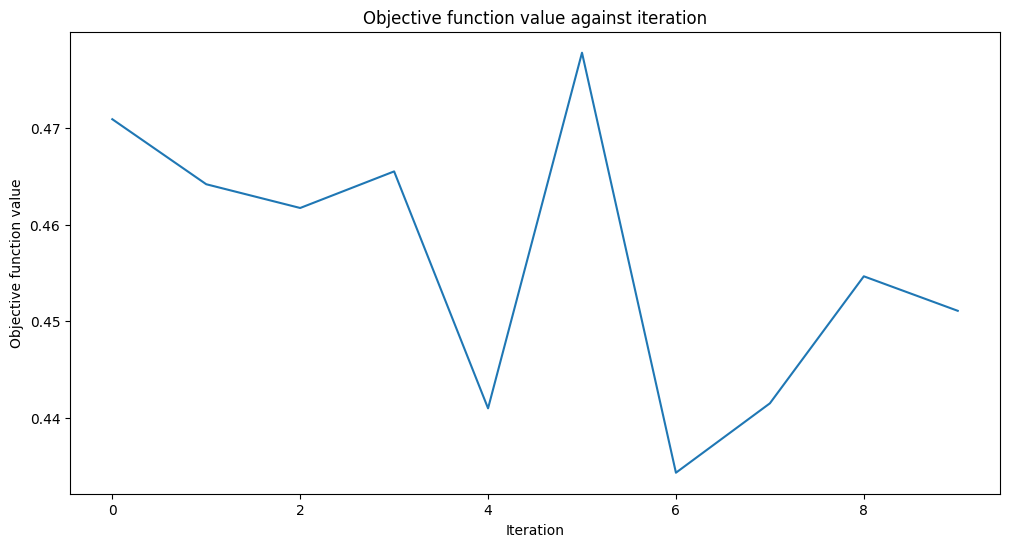

Fit in 1.37 seconds
0 RealAmplitudes [0, 1, 2, 3, 4]
1 barrier [0, 1, 2, 3, 4, 5, 6, 7, 8]
2 h [8]
3 cswap [8, 2, 5]
4 cswap [8, 3, 6]
5 cswap [8, 4, 7]
6 h [8]
7 measure [8]
our circuit ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15]), ParameterVectorElement(θ[16]), ParameterVectorElement(θ[17]), ParameterVectorElement(θ[18]), ParameterVectorElement(θ[19]), ParameterVectorElement(θ[20]), ParameterVectorElement(θ[21]), ParameterVectorElement(θ[22]), ParameterVectorElement(θ[23]), ParameterVectorElement(θ[24]), ParameterVectorElement(θ[25]), Pa

ValueError: Input param `θ[0]` not present in circuit

In [171]:
#Sets up qiskit's neural network from the library
observable = SparsePauliOp.from_list([("Z" + "I" * 9, 1)])
our_circ = make_auto_encoder_circuit();
print("our circuit", our_circ.parameters)
print("----------------")
print("their circuit", feature_map.parameters)
qnn = EstimatorQNN(
    circuit=ml_circuit.decompose(),
    observables=observable,
    input_params= our_circ.parameters,
    weight_params=network.parameters,
)

In [35]:
#Function used in classifier to plot objective function at each iteration
max_iters = 600
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    #print(len(objective_func_vals)/max_iters*100, end="\r")
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [36]:
#Sets up Classifier with COBYLA optimizer
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=max_iters),
    callback=callback_graph
)

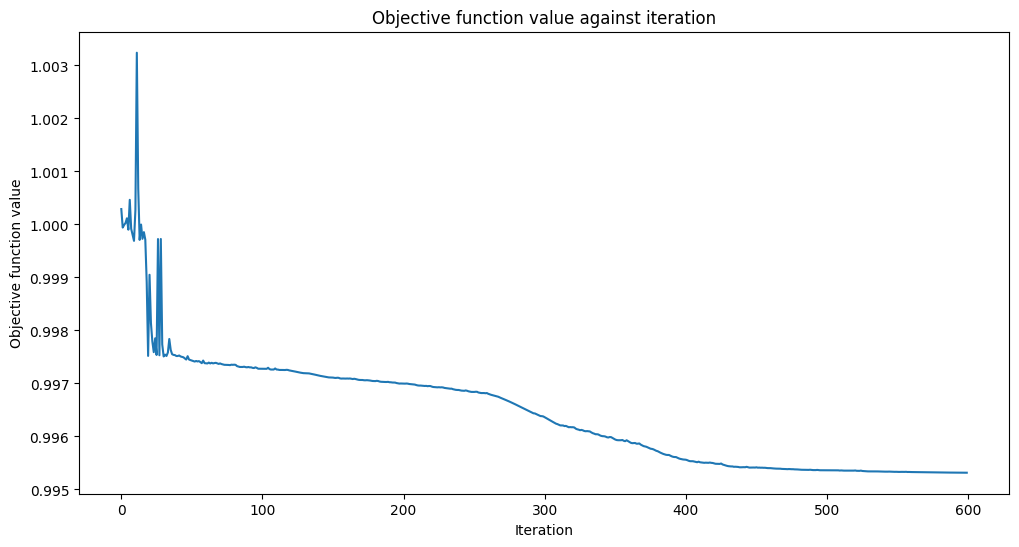

Accuracy from the test data : 52.66%


In [37]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#Trains the network and plots objective function vs iteration
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(predictors, labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(predictors, labels), 2)}%")

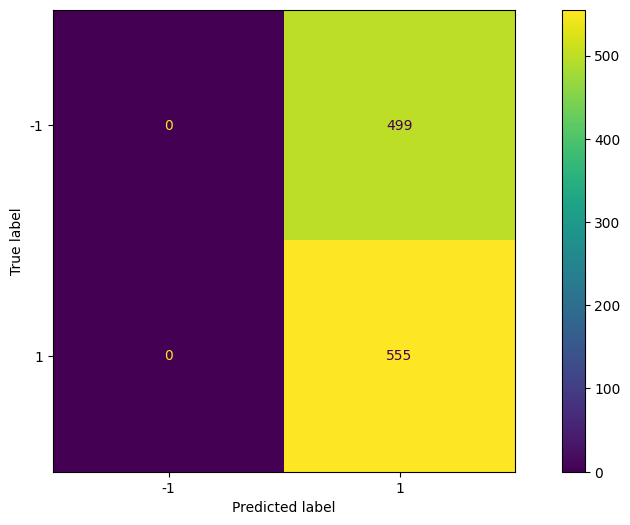

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, classifier.predict(predictors))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1,1])
display.plot()
plt.show()